## Question 3

Task: finding locations to clean while avoiding high traffic areas

Environment: screenshot here

Action space: {rotate CW, rotate CCW, move forward} 

    - if the robot is currently facing up, and it wants to do a 180 turn, 
    - it'll need to 1) rotate CW, 2) rotate CW, 3) move foward


Reward function: 

    * +10 for reaching cleaning locations
    * -10 for entering high traffic areas
    * -1 for any action

**Folder setup**
```
Question3
- question3.ipynb
- clean_airport_env.py
- generalized_policy_iteration.py
- plotting.py
- robot_enums.py
- simple_grid_env.py
```

In [1]:
# Import the functions provided to us
import numpy as np
from simple_grid_env import SimpleGridEnv
from clean_airport_env import CleanAirportEnv
from robot_enums import Heading
from robot_enums import Action
from plotting import ValueFunctionPlotter
from plotting import PolicyPlotter

<Figure size 720x720 with 0 Axes>

In [30]:
# forward_mapper  = {0: (1, 0),
#                    1: (0, 1),
#                    2: (-1, 0),
#                    3: (0, -1)}

forward_mapper  = {0: (1, 0),
                   1: (0, 1),
                   2: (-1, 0),
                   3: (0, -1)}                  

direction_lookup = ['N', 'E', 'S', 'W']
action_lookup = ['Foward', 'CW', 'CCW', 'terminate']

In [14]:
print(policy[:, :, 1])

policy[0, 3, 1]

[[0 0 0 2]
 [0 0 0 0]
 [1 1 0 1]]


2

**General Policy Iteration Class**

In [35]:
class GeneralPolicyIteration(object):

    def __init__(self, environment, discount_factor):
        ''' Constructs a new policy iteration class instance
        Args:
        Environment: a simpleGrid() object 
            contains the grid space, the win states, and the lose states
        Discount_factor: float
        '''
        self.env = environment
        self.discount_factor = discount_factor

    def get_state_value(self, i, j, k, policy, iteration):
        '''
        gets the value for the current state 
        
        Args
        ----------------------------------------
        i: row
        j: col
        k: direction the robot is facing
        policy: the current policy (can be improved by not passing the entire policy)
        iteration: iteration count, exits recursion if larger than max_iteration 
        
        Returns
        ----------------------------------------
        state value
        '''
        max_iterations = 1000

        if iteration >= max_iterations:
            return 0

        if (i, j) in win_states:
            return 10
        elif (i, j) in lose_states:
            return -10

        action = policy[i][j][k]
        
        # Compute the next state ii, jj, kk
        ii, jj, kk = i, j, k
        if action == 0: # Forward
            ii, jj = forward_mapper[k][0] + i, forward_mapper[k][1] + j
        elif action == 1: # CW
            kk = (k+1) % 4
        elif action == 2: # CCW
            kk = (k-1) % 4

        # Bound to grid
        ii = max(ii, 0)
        ii = min(ii, 2)
        jj = max(jj, 0)
        jj = min(jj, 3)

        return self.get_state_value(ii, jj, kk, policy, iteration+1) - 1

    def policy_evaluation(self, policy, theta=1e-9, max_iterations=1e3):
        '''
        Evaluates a given policy

        Args
        ----------------------------------------
        policy: the policy to be evaluated row x col x 4 array
        theta: float, used for decay
        max_iterations: int, default to 1e3, used to exit recursion

        Returns
        ----------------------------------------
        V: row x col x 4 array indicating value of every state
        '''
        # Initialise value function for each state as zero, V(terminal) = 0, others can be arbitrary
        V = np.zeros([self.env.grid_rows, self.env.grid_cols, 4])

        for k in range(4):
            for i, row in enumerate(V[:, :, k]):
                for j, s in enumerate(V[i, :, k]):
                    # print(V_north[i][j])
                    V[i, j, k] = self.get_state_value(i, j, k, policy, 0)
        
        return V

    def policy_improvement(self, policy, V):

        '''
        Iterates the entire policy grid once by picking a new policy which maximises the state value for every state
        Args
        ----------------------------------------
        policy: the policy grid to be updated
        V: the current state value function to be compared to

        Returns
        ----------------------------------------
        policy: updated policy grid
        stable_policy: bool, whether or not the policy stable
        '''

        stable_policy = True

        for k in range(4):
            for i, row in reversed(list(enumerate(V[:, :, k]))):
                for j, state in reversed(list(enumerate(V[i, :, k]))):
                    dummy_policy = policy.copy()
                    for action in range(3):
                        old_value = V[i, j, k]
                        dummy_policy[i, j, k] = action
                        new_value = self.get_state_value(i, j, k, dummy_policy, 0)
                        if new_value > old_value:
                            old_value = new_value
                            policy[i, j, k] = action
                            stable_policy=False
        
        return policy, stable_policy


    def policy_iteration(self, max_iterations=1e3):

        '''
        Policy iteration (using iterative policy evaluation).

        Args
        ----------------------------------------
        max_iteration: Maximum number of iterations before automatically returned.

        Returns
        ----------------------------------------
        policy: updated policy grid
        V: value grid
        '''
        # Initialize a random policy
        # np.random.seed(123)
        policy = np.random.randint(0, self.env.nA, size=(self.env.grid_rows, self.env.grid_cols, len(Heading)))
        V = np.zeros([self.env.grid_rows, self.env.grid_cols, len(Heading)])

        # Create functions for plotting
        value_function_plotter = ValueFunctionPlotter()
        # value_function_plotter.plot(V)
        policy_plotter = PolicyPlotter()
        policy_plotter.plot(policy)

        # for i in range(int(max_iterations)):
        for i in range(10):
            policy, stable = self.policy_improvement(policy, V)
            policy_plotter.plot(policy)        
            V = self.policy_evaluation(policy)
            value_function_plotter.plot(V)
            if stable:
                print('is stable')
                break
            

        return policy, V

    """
    @info:  Value iteration
            theta: Stopping condition.
            max_iteration: Maximum number of iterations before automatically returned.
    @return: policy: State to action mapping.
             V: State-value function.
    """

    def value_iteration(self, theta=1e-9, max_iterations=1e3):
        # Initialize a random policy
        policy = np.random.randint(0, self.env.nA, size=(self.env.grid_rows, self.env.grid_cols, len(Heading)))
        V = np.zeros([self.env.grid_rows, self.env.grid_cols, len(Heading)])

        # Create functions for plotting
        value_function_plotter = ValueFunctionPlotter()
        policy_plotter = PolicyPlotter()

        value_function_plotter.plot(V)
        policy_plotter.plot(policy)

        print("value_iteration: Insert your implementation here")

        return policy, V


In [38]:
state_1_reward = -4
   


120

[4, 3, 4]
4
[4, 3, 4]
4
[4, 3, 4]
4
new_action at row2, column3, facingFoward:2
[4, 3, 4]
4
[4, 3, 4]
4
[4, 3, 4]
4
[4, 3, 4]
4
[4, 3, 4]
4
[4, 3, 4]
4
[4, 3, 4]
4
[4, 3, 4]
4
[4, 3, 4]
4
[4, 3, 4]
4
[4, 3, 4]
4
[4, 3, 4]
4
is stable


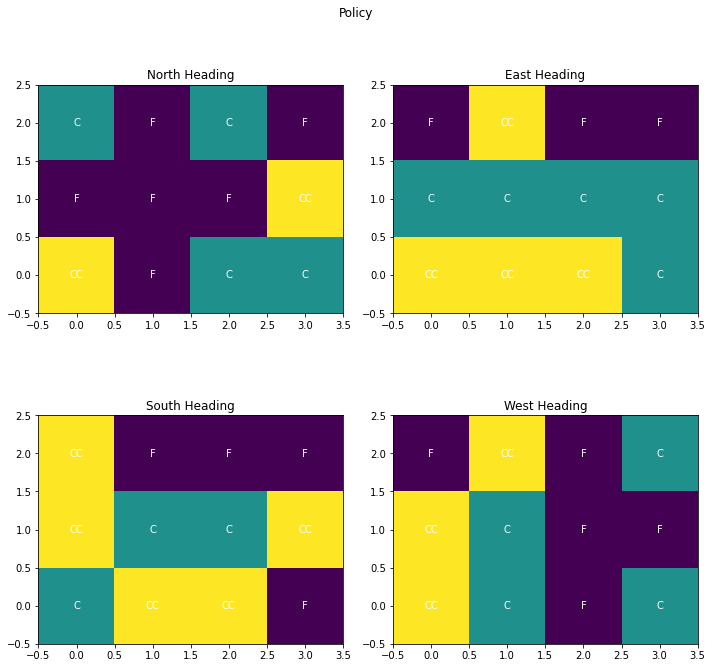

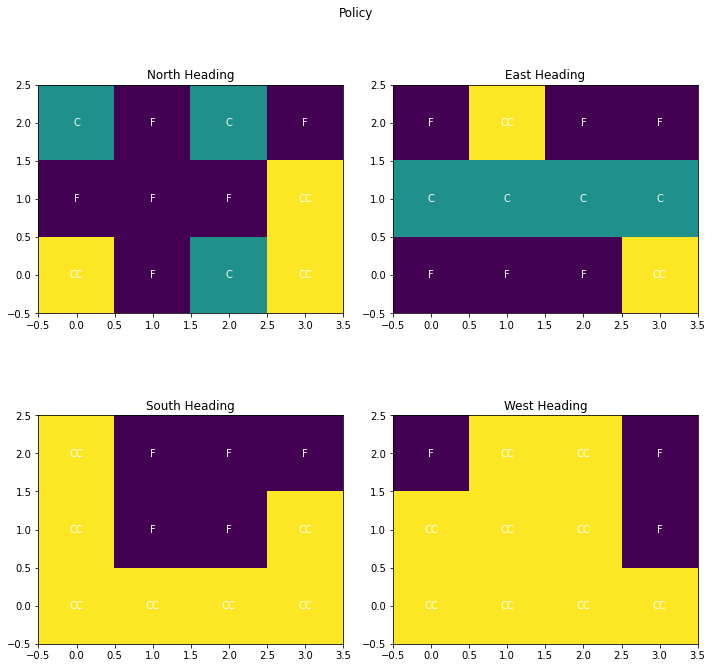

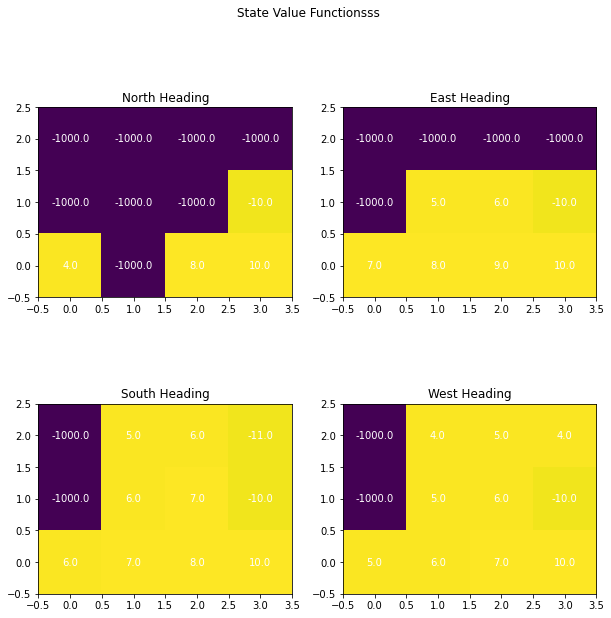

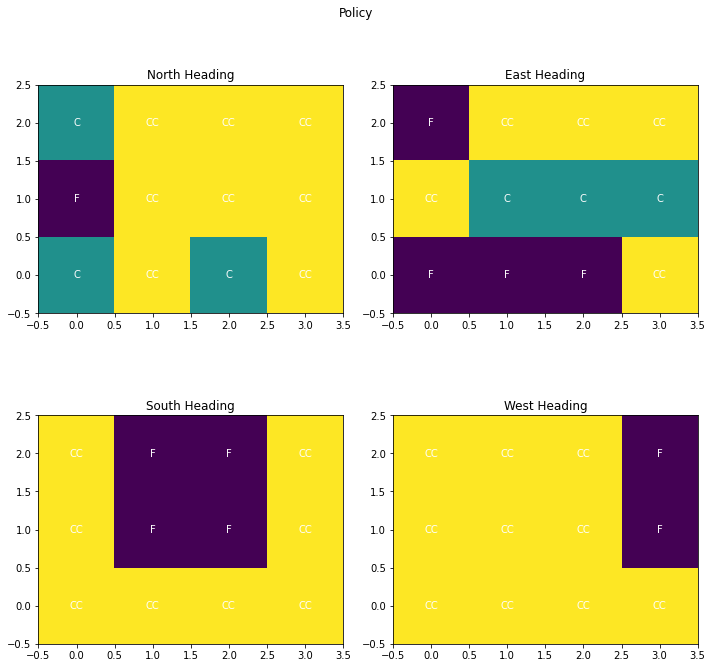

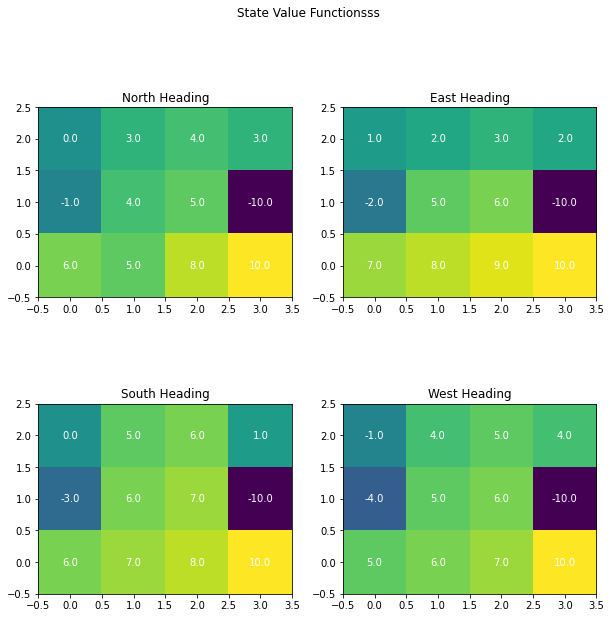

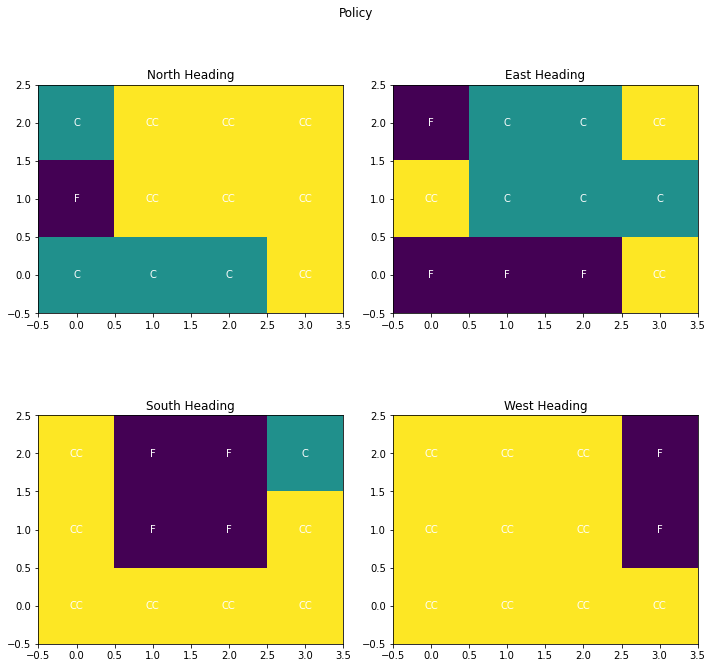

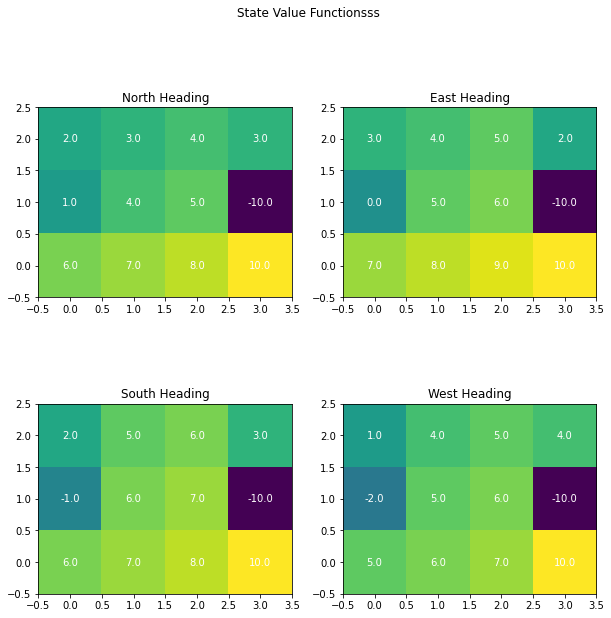

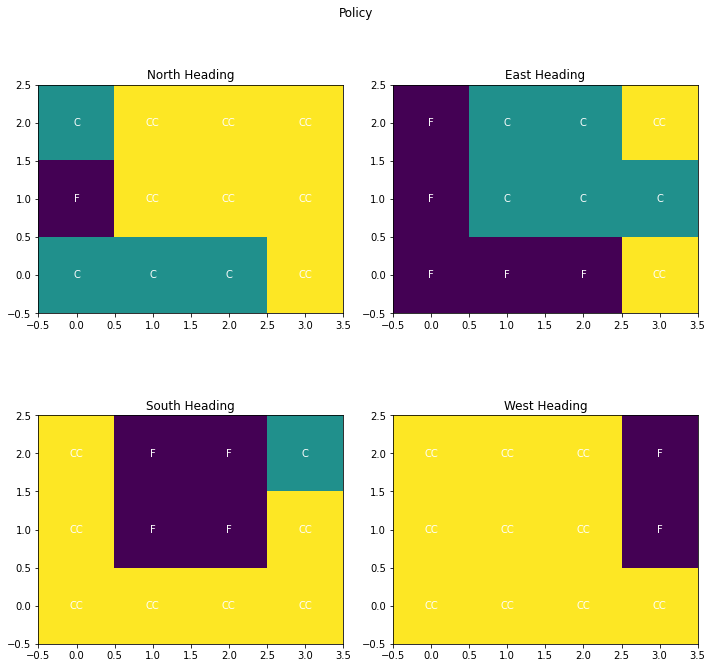

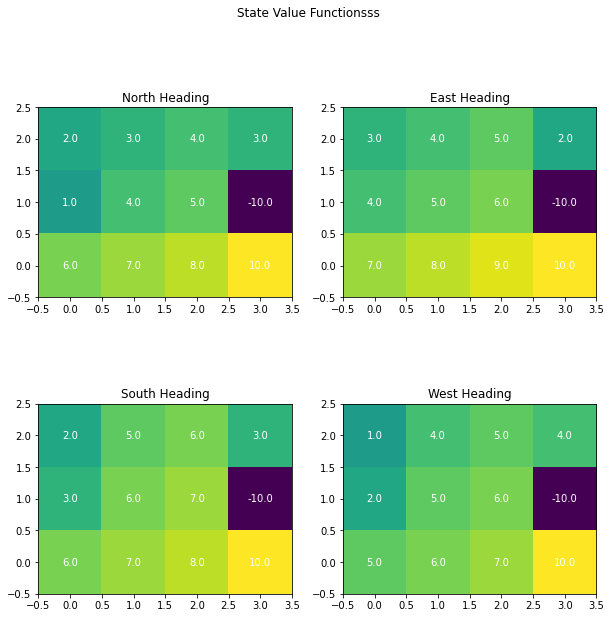

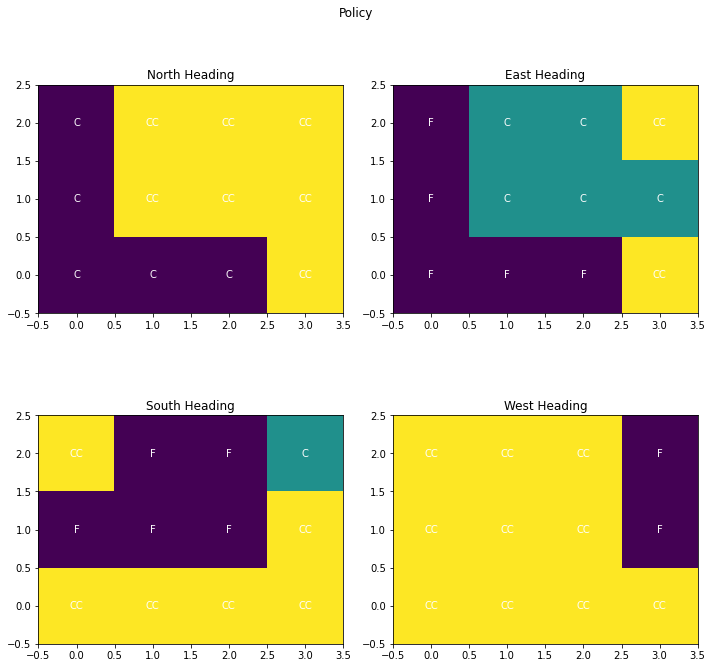

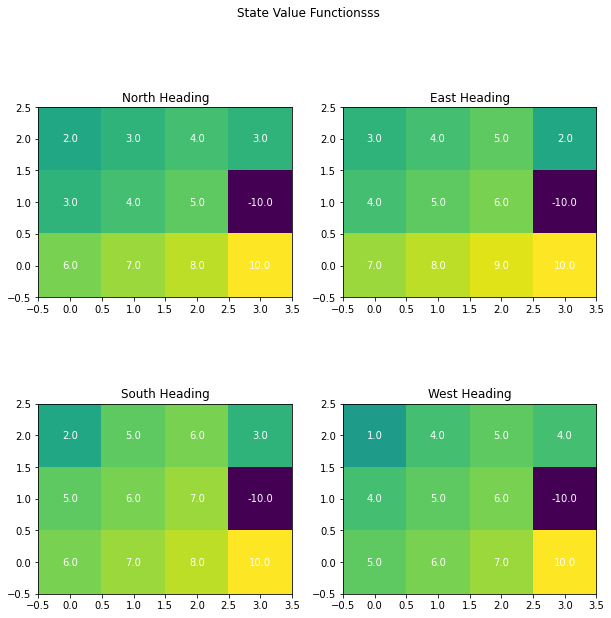

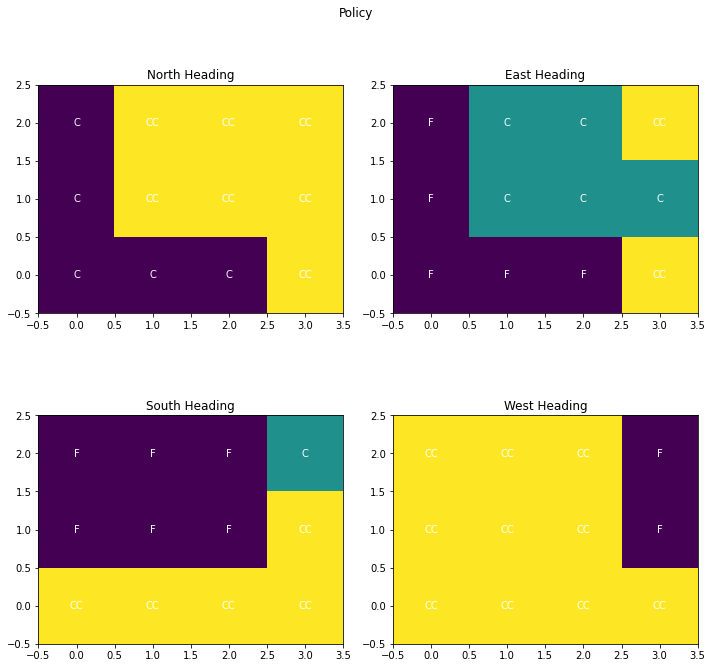

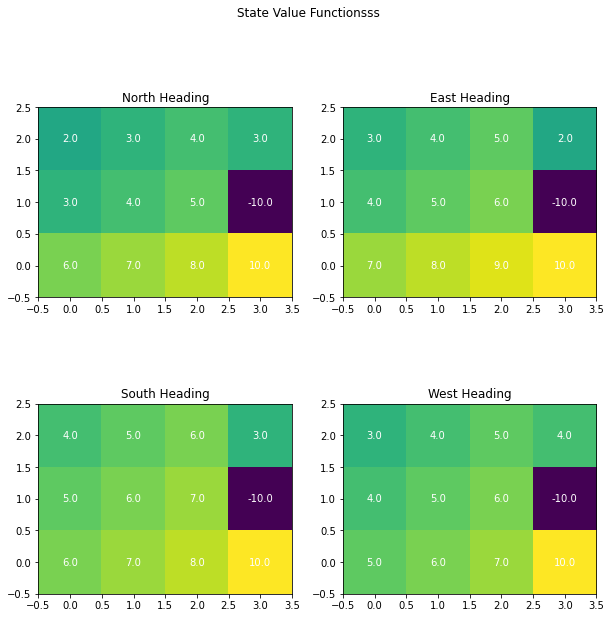

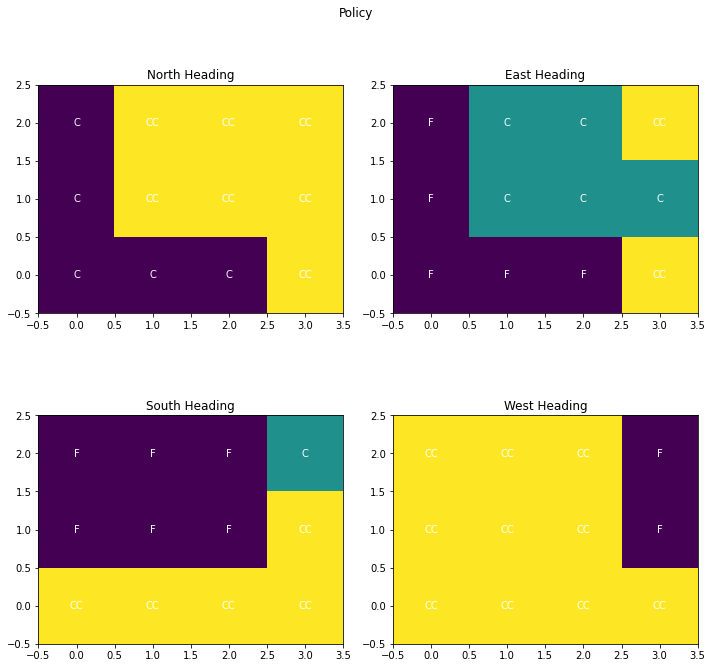

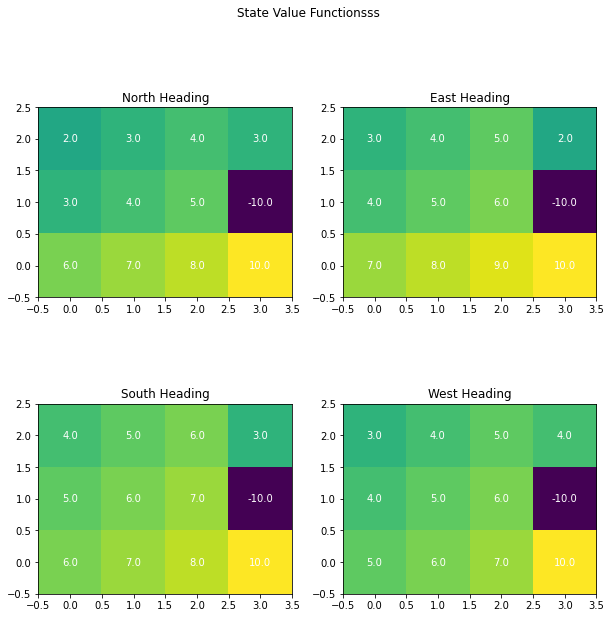

In [36]:
# Simple Grid Env
grid_rows = 3
grid_cols = 4
start_state = (0, 0, Heading.NORTH)

# Simple example
win_states = [(0, 3)]
lose_states = [(1, 3)]

# Simple gridworld
robot = SimpleGridEnv(grid_rows, grid_cols, start_state, win_states, lose_states)

# Run the requested algorithms
gpi = GeneralPolicyIteration(robot, discount_factor=1.0)

policy, value = gpi.policy_iteration()

[4, 3, 4]
4
[4, 3, 4]
4
[4, 3, 4]
4
[4, 3, 4]
4
[4, 3, 4]
4
[4, 3, 4]
4
[4, 3, 4]
4
[4, 3, 4]
4
[4, 3, 4]
4
[4, 3, 4]
4
[4, 3, 4]
4
[4, 3, 4]
4
[4, 3, 4]
4
[4, 3, 4]
4
[4, 3, 4]
4
[4, 3, 4]
4
[4, 3, 4]
4
[4, 3, 4]
4
[4, 3, 4]
4
is stable


(array([[[1, 0, 2, 2],
         [1, 0, 2, 2],
         [1, 0, 2, 2],
         [2, 2, 2, 2]],
 
        [[1, 0, 0, 2],
         [2, 1, 0, 2],
         [2, 1, 0, 2],
         [0, 2, 1, 1]],
 
        [[1, 0, 0, 2],
         [2, 1, 0, 2],
         [2, 1, 0, 2],
         [2, 2, 1, 0]]]),
 array([[[  6.,   7.,   6.,   5.],
         [  7.,   8.,   7.,   6.],
         [  8.,   9.,   8.,   7.],
         [ 10.,  10.,  10.,  10.]],
 
        [[  3.,   4.,   5.,   4.],
         [  4.,   5.,   6.,   5.],
         [  5.,   6.,   7.,   6.],
         [-10., -10., -10., -10.]],
 
        [[  2.,   3.,   4.,   3.],
         [  3.,   4.,   5.,   4.],
         [  4.,   5.,   6.,   5.],
         [  3.,   2.,   3.,   4.]]]))

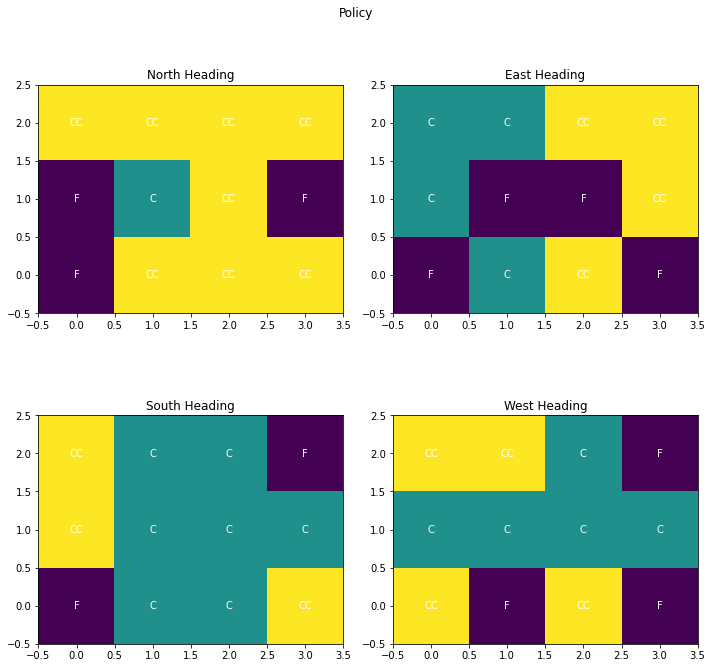

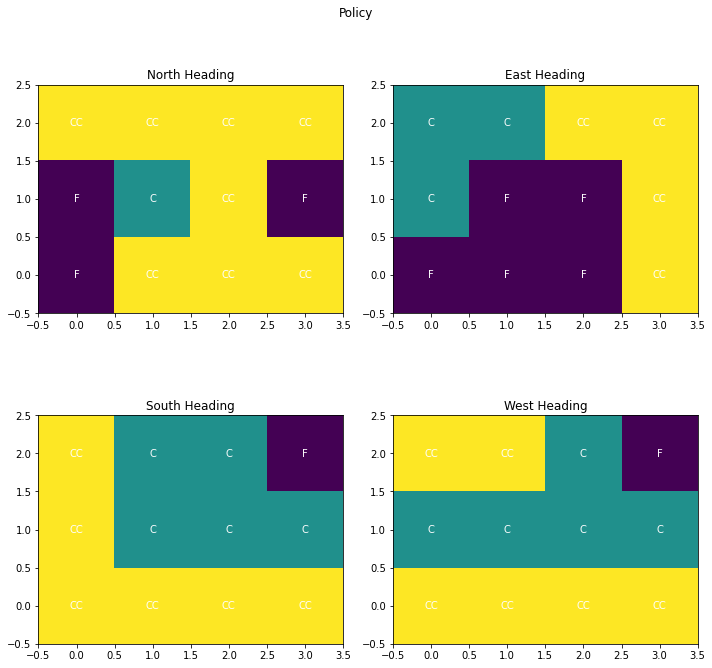

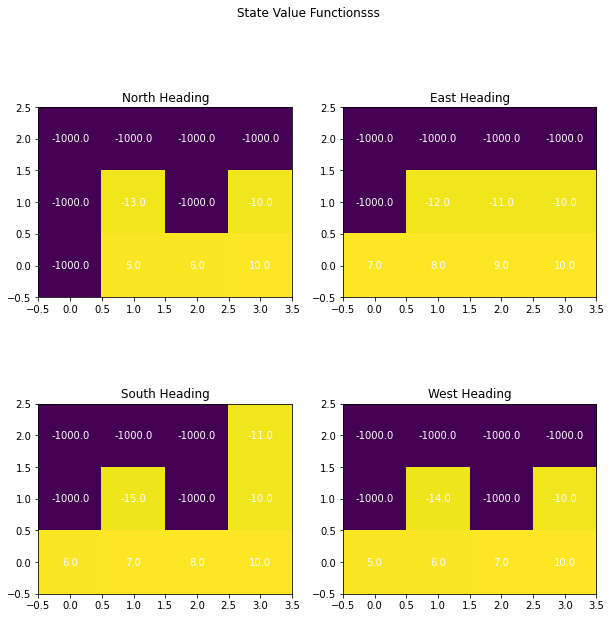

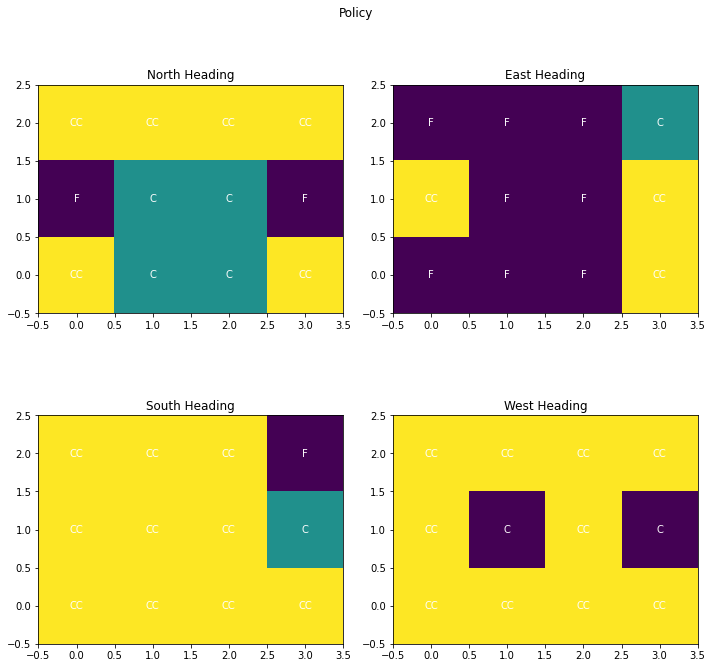

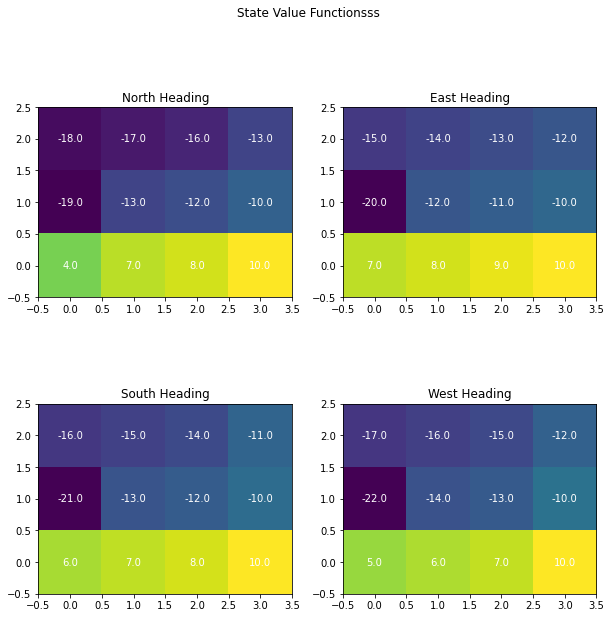

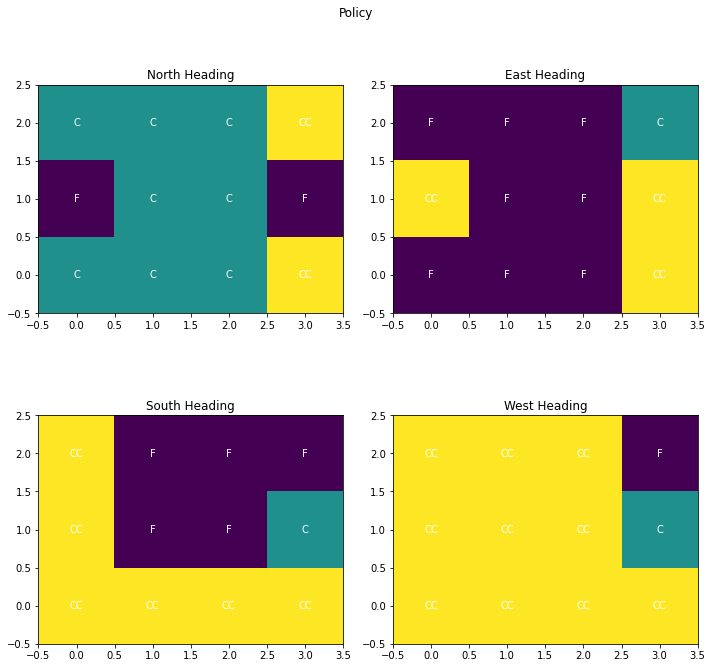

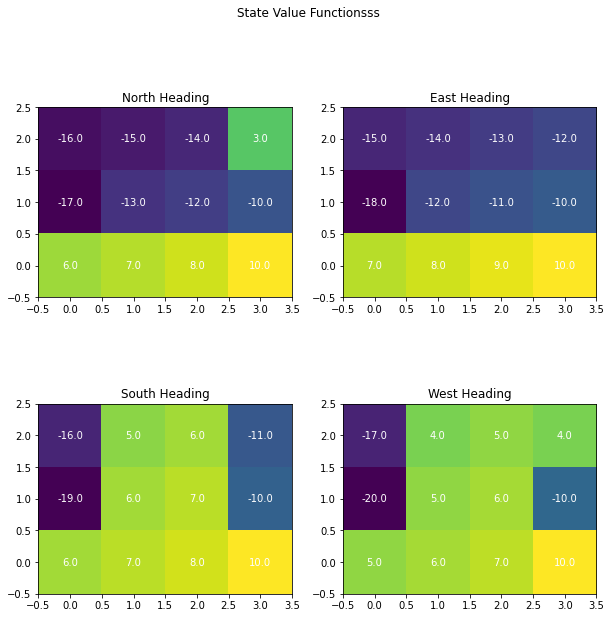

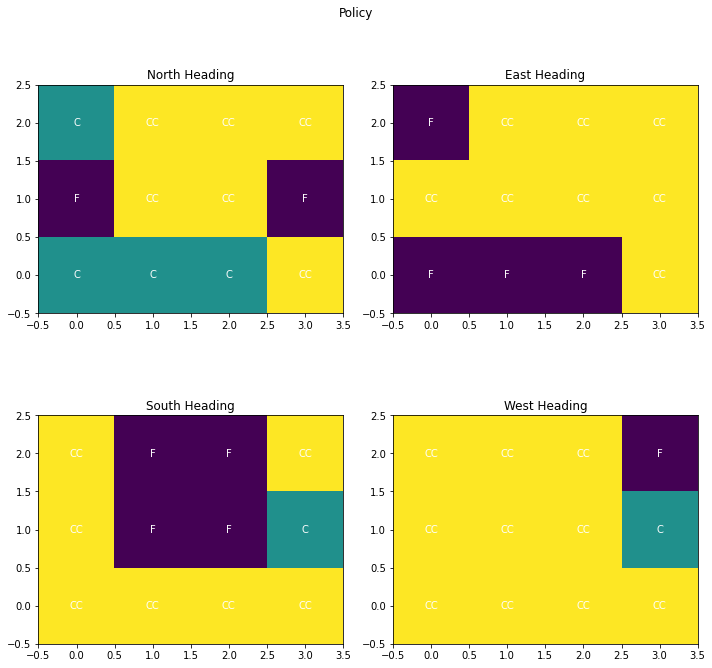

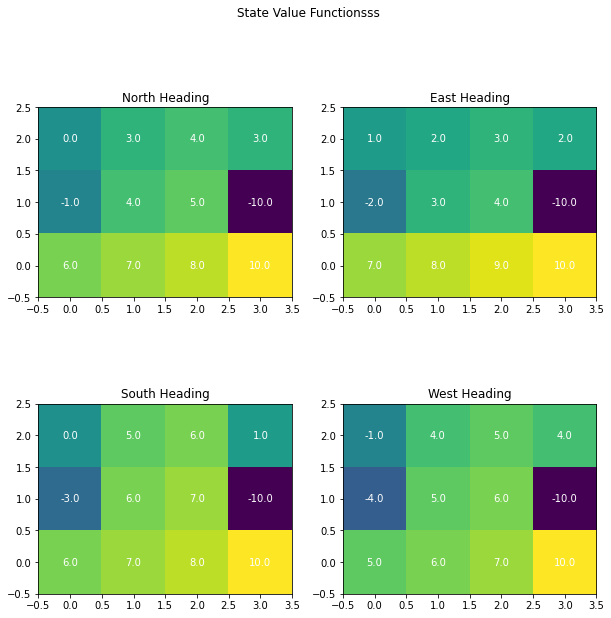

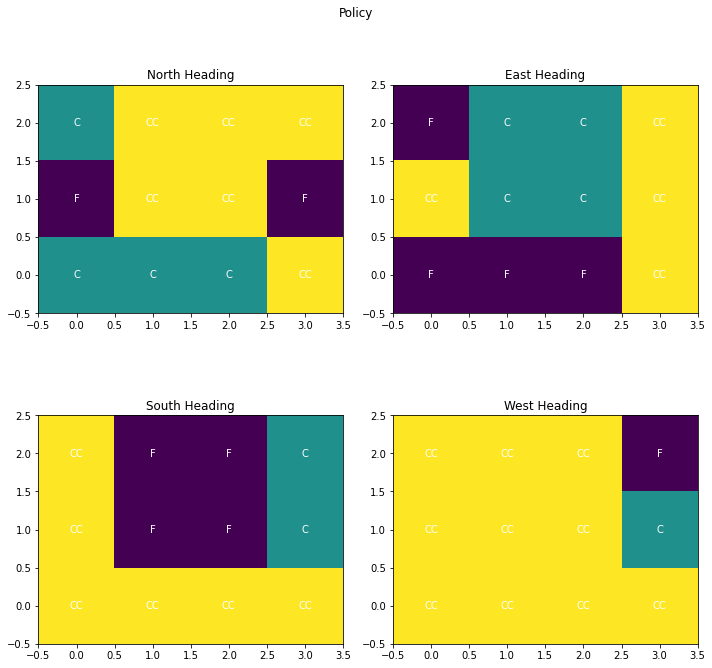

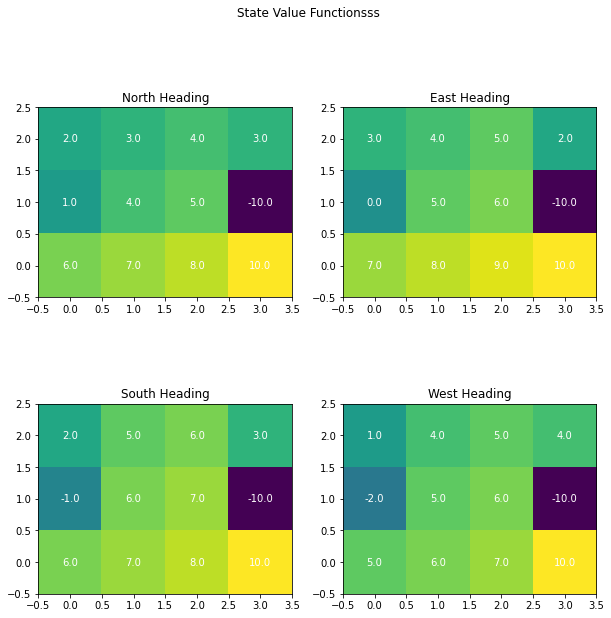

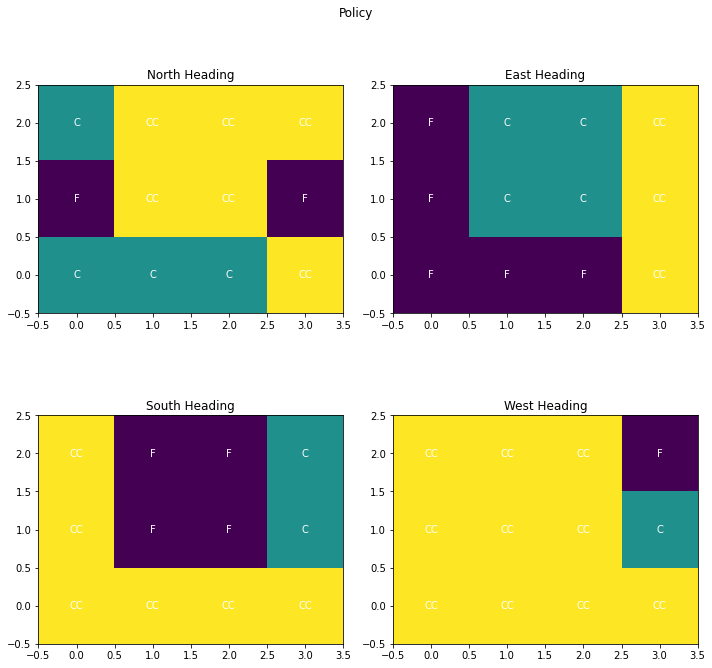

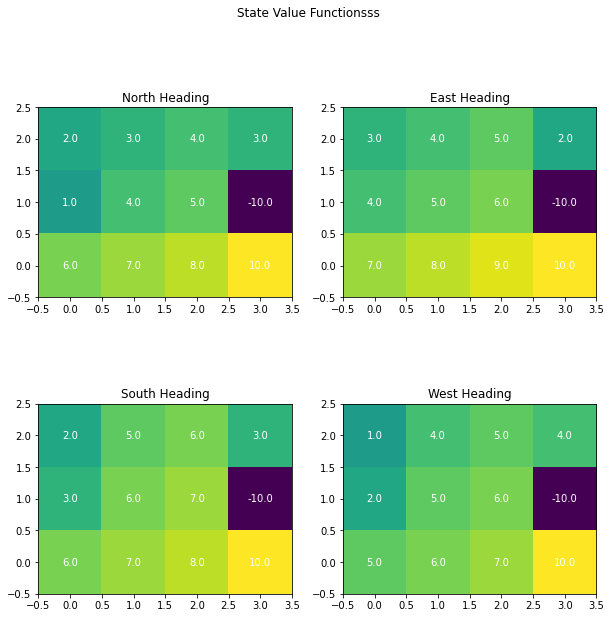

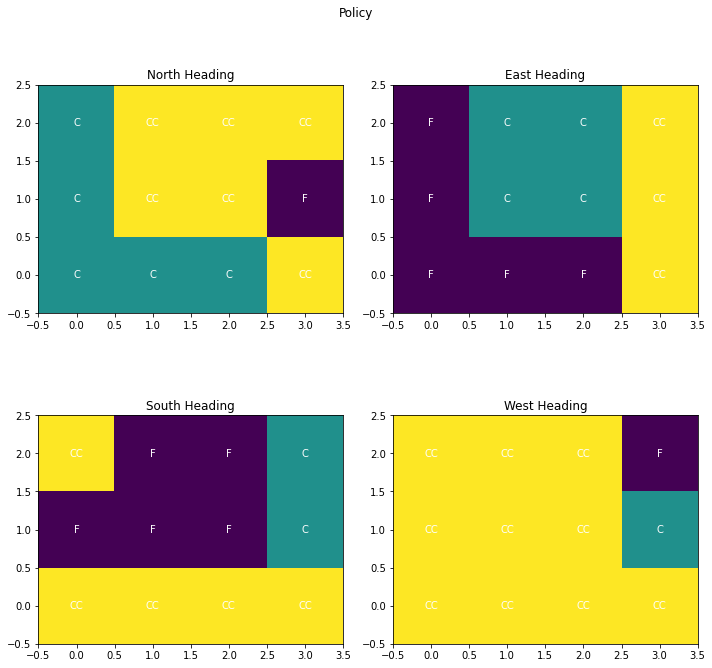

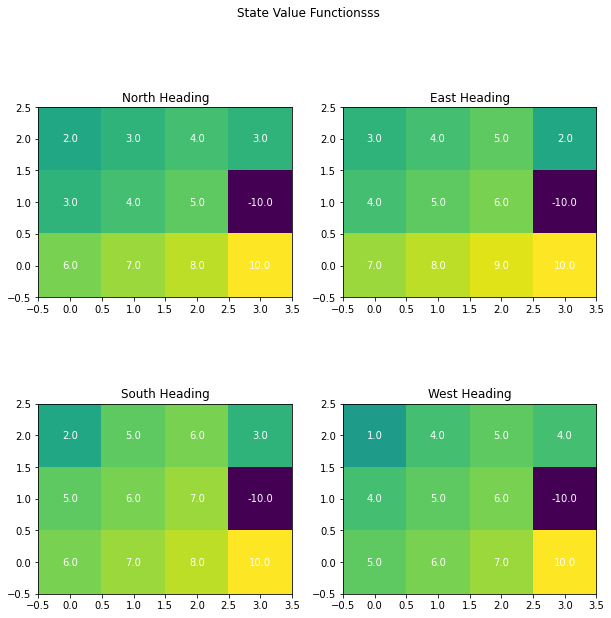

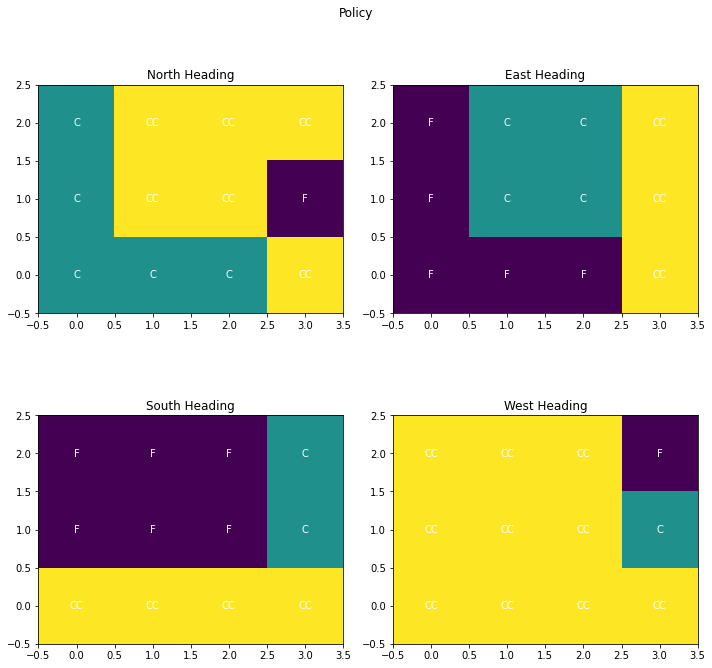

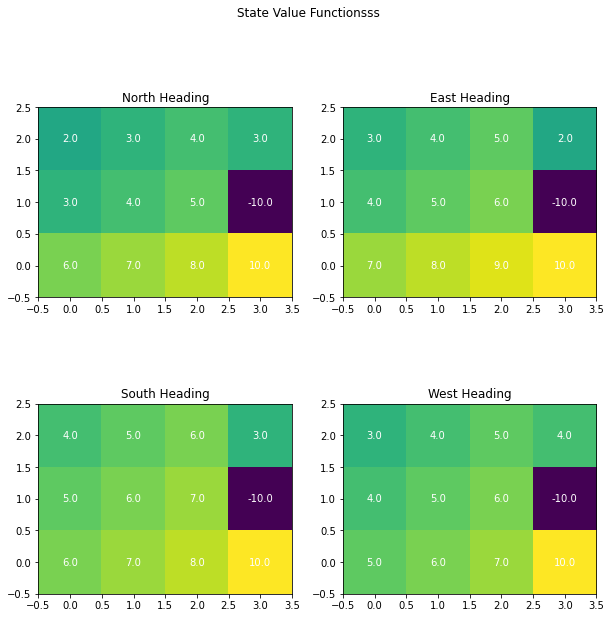

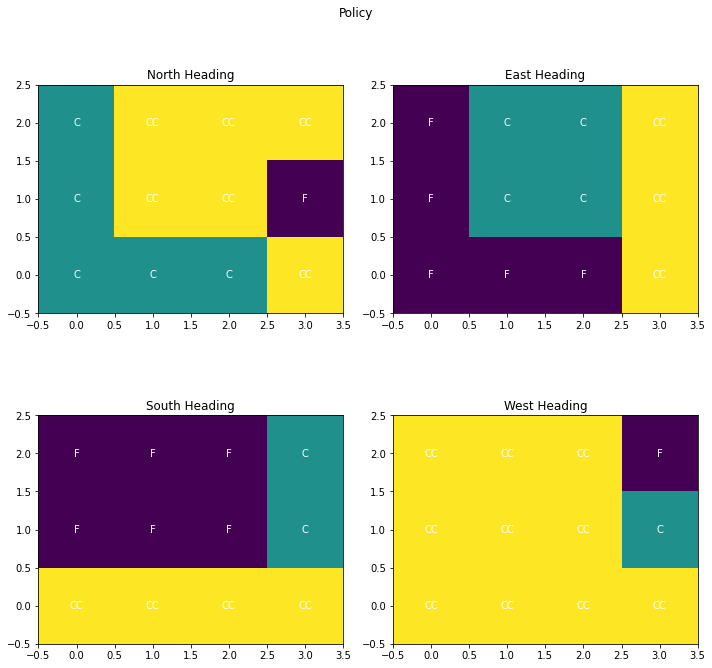

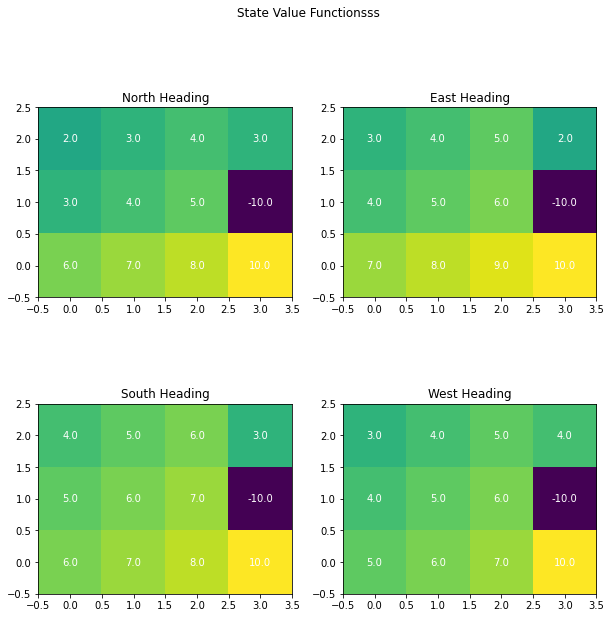

In [37]:
gpi.policy_iteration()
